In [1]:
'''
Read reviews from a JSON-formatted file into an array.
'''
import json
import string
import re
import keras
import numpy as np
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

lines = [];
num_pos = 0;
num_neg = 0;
num_total = 75000;

with open('/Users/edgarleung/Downloads/yelp_dataset/yelp_academic_dataset_review.json', 'r',encoding='utf8') as f:
    for line in f:
        if (len(lines) >= (num_total * 2)):
            break;

        json_info = json.loads(line);

        if json_info['stars'] > 3:
            if num_pos > num_total:
                continue;
            num_pos = num_pos + 1;
        elif json_info['stars'] < 3:
            if num_neg > num_total:
                continue;
            num_neg = num_neg + 1;
        else:
            continue;

        lines.append(json.loads(line));

'''
Separate line data into reviews and labels
'''
reviews = [line['text'] for line in lines];

stars = [line['stars'] for line in lines];
labels = ['1' if star > 3 else '0' for star in stars];

'''
Clean each document by removing unnecesary characters and splitting by space.
'''

Using TensorFlow backend.


'\nClean each document by removing unnecesary characters and splitting by space.\n'

In [2]:
# Use a Keras Tokenizer and fit on the reviews
tokenizer = Tokenizer();
tokenizer.fit_on_texts(reviews);
reviews_encoded = np.array(tokenizer.texts_to_sequences(reviews));
' '.join(map(str,reviews_encoded[0]))

'1 176 6 540 18 1 101 109 23 3 1574 27103 19 4498 6319 7433 1 712 31 83 118 5 120 126 2203 618 176 1 4772 5591 6 91 620 8 1 214 2 819 7 2545 10 1 30 27103 11 5 120 126 472 38 7648 113 8 758 282 1575 191 123 4787 105 13 280 229 38 21 51 54 30 21 934 49 13 24 5 4772 10 5 1027 3 934 229 62 21 150'

In [3]:
sequence_dict = tokenizer.word_index;
# reverse - index to word
word_dict = dict((num, val) for (val, num) in sequence_dict.items());

In [4]:
#for i,(a,b) in enumerate(zip(reviews_encoded,text_sequences)):
#    if (a!=b):
#        print(review_cleans[i])

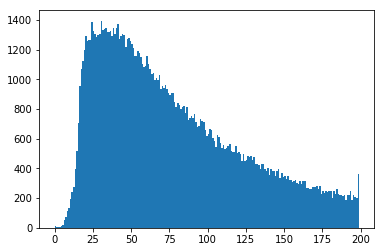

In [5]:
# Plot a Histogram of length of reviews
lengths = [len(x) for x in reviews_encoded];
plt.hist(lengths, bins=range(200))
plt.show()

In [6]:
# Truncate and Pad reviews at a Maximum cap of 60 words.
max_cap = 60;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

In [7]:
' '.join(list(map(lambda x: word_dict[x] if x>0 else '0', X[0])))

"the pizza was okay not the best i've had i prefer biaggio's on flamingo fort apache the chef there can make a much better ny style pizza the pizzeria cosmo was over priced for the quality and lack of personality in the food biaggio's is a much better pick if youre going for italian family owned home made recipes people"

In [8]:
# Obtain a One-hot Y array for each review label.
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

Y

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [9]:
# Get a randomized sequence of positions to shuffle reviews
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X = X[random_posits];
Y = Y[random_posits];

In [10]:
# Divide the reviews into Training, Dev, and Test data.
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

X_train, Y_train = X[:train_cap], Y[:train_cap];
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap];
X_test, Y_test = X[dev_cap:], Y[dev_cap:]


In [11]:
model = Sequential();
model.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
model.add(LSTM(150, return_sequences=True));
model.add(LSTM(150));
model.add(Dense(150, activation='relu'));
model.add(Dense(150, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 60)            6521220   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 150)           126600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 6,874,022
Trainable params: 6,874,022
Non-trainable params: 0
_________________________________________________________________


In [12]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [13]:
optimizer = Adam(lr=0.001, decay=0.0001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
history = model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))


Train on 127500 samples, validate on 12000 samples
Epoch 1/10
127500/127500 [==============================] - 562s 4ms/step - loss: 0.2615 - acc: 0.8918 - val_loss: 0.2213 - val_acc: 0.9102
Epoch 2/10
127500/127500 [==============================] - 581s 5ms/step - loss: 0.1701 - acc: 0.9343 - val_loss: 0.2573 - val_acc: 0.9082
Epoch 3/10
127500/127500 [==============================] - 822s 6ms/step - loss: 0.1247 - acc: 0.9536 - val_loss: 0.2514 - val_acc: 0.9151
Epoch 4/10
127500/127500 [==============================] - 726s 6ms/step - loss: 0.0896 - acc: 0.9677 - val_loss: 0.2543 - val_acc: 0.9079
Epoch 5/10
127500/127500 [==============================] - 704s 6ms/step - loss: 0.0625 - acc: 0.9787 - val_loss: 0.2529 - val_acc: 0.9057
Epoch 6/10
127500/127500 [==============================] - 683s 5ms/step - loss: 0.0443 - acc: 0.9849 - val_loss: 0.3592 - val_acc: 0.9087
Epoch 7/10
127500/127500 [==============================] - 778s 6ms/step - loss: 0.0304 - acc: 0.9900 - val_

In [14]:
# Obtain predictions
predictions = model.predict_classes(X_test)

# Convert Y_test to the same format as predictions
actuals = [0 if y[0] == 1 else 1 for y in Y_test];

# Use SkLearn's Metrics module
accuracy_score(predictions, actuals)

0.8998095238095238

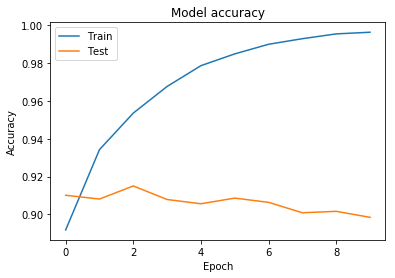

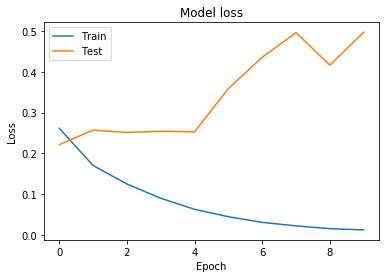

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()